### Imports

In [1]:
from matplotlib import pyplot as plt
from data import load_data, load_narx_data
from matplotlib import pyplot as plt
import numpy as np
import torch
from data import load_narx_data
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared, Matern, Product
from scipy.sparse import csr_matrix
import time
import json

In [2]:
# Settings
n_a, n_b = 2, 2
Split = [0.6, 0.2, 0.2] # split; [training, validation, test]
restart = 10 # has large effect on original method duration
# Define the filename
# filename = 'resultsSparseX.json'
# filename = 'resultsSparseXY.json'
filename = 'resultsOriginal.json'

total_number_of_points = [500, 1000, 2000, 3000, 5000] # total number of points to consider from the larger dataset (starting from index 0)

In [3]:
results = {}
for points in total_number_of_points:

    # Create data
    Xtrain,Ytrain = load_narx_data(n_a, n_b, points, section="train", split=Split, as_tensor=True)
    Xval,Yval = load_narx_data(n_a, n_b, points, section="validation", split=Split, as_tensor=True)
    Xtest,Ytest = load_narx_data(n_a, n_b, points, section="test", split=Split, as_tensor=True)
    XtrainSparse = csr_matrix(Xtrain)
    YtrainSparse = csr_matrix(Ytrain)
    Yval = Yval.numpy()  # Convert Yval from Tensor to NumPy array
    Ytest = Ytest.numpy()  # Convert Ytest from Tensor to NumPy array


    # kernel
    kernel = RBF(length_scale=1) + WhiteKernel(noise_level=0.1)
    reg = GaussianProcessRegressor(kernel, n_restarts_optimizer=restart)

    # Start timer
    start_time = time.perf_counter()

    # Fitting
    if filename == 'resultsSparseX.json':
        reg.fit(XtrainSparse.toarray(), Ytrain) # Sparse X
    elif filename == 'resultsSparseXY.json':
        reg.fit(XtrainSparse.toarray(), YtrainSparse.toarray().transpose()) # Sparse XY
    elif filename == 'resultsOriginal.json':
        reg.fit(Xtrain, Ytrain) # Original

    # End timer
    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    print("")
    print("Elapsed time:", elapsed_time)

    # NRMS calculation
    Yval_pred, Yval_pred_std = reg.predict(Xval, return_std=True) 
    NRMS_val = np.mean((Yval_pred-Yval)**2)**0.5/np.std(Yval)

    print(f'Validation NRMS= {NRMS_val}')

    Ytest_pred, Ytest_pred_std = reg.predict(Xtest, return_std=True)
    NRMS_test = np.mean((Ytest_pred-Ytest)**2)**0.5/np.std(Ytest)

    print(f'Test NRMS= {NRMS_test}')
    print("")

    # Saving results
    results[points] = [elapsed_time, NRMS_val, NRMS_test]

Considering 500 datapoints
Using 300 datapoints for training set
Considering 500 datapoints
Using 100 datapoints for validation set
Considering 500 datapoints
Using 100 datapoints for test set

Elapsed time: 0.8698370000000004
Validation NRMS= 0.01004112654076664
Test NRMS= 0.011934413876786227

Considering 1000 datapoints
Using 600 datapoints for training set
Considering 1000 datapoints
Using 200 datapoints for validation set
Considering 1000 datapoints
Using 200 datapoints for test set

Elapsed time: 5.999110399999999
Validation NRMS= 0.01491487043673199
Test NRMS= 0.009406775051192971

Considering 2000 datapoints
Using 1200 datapoints for training set
Considering 2000 datapoints
Using 400 datapoints for validation set
Considering 2000 datapoints
Using 400 datapoints for test set

Elapsed time: 31.845064199999996
Validation NRMS= 0.011839070963566562
Test NRMS= 0.011756808181803467

Considering 3000 datapoints
Using 1800 datapoints for training set
Considering 3000 datapoints
Using 6

c:\Users\20191695\Anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)



Elapsed time: 82.2232085
Validation NRMS= 0.008775271946927789
Test NRMS= 0.011250743089245495

Considering 5000 datapoints
Using 3000 datapoints for training set
Considering 5000 datapoints
Using 1000 datapoints for validation set
Considering 5000 datapoints
Using 1000 datapoints for test set

Elapsed time: 343.5592102
Validation NRMS= 0.008590013680868917
Test NRMS= 0.008940620701988094



# Results

Make some nice plots

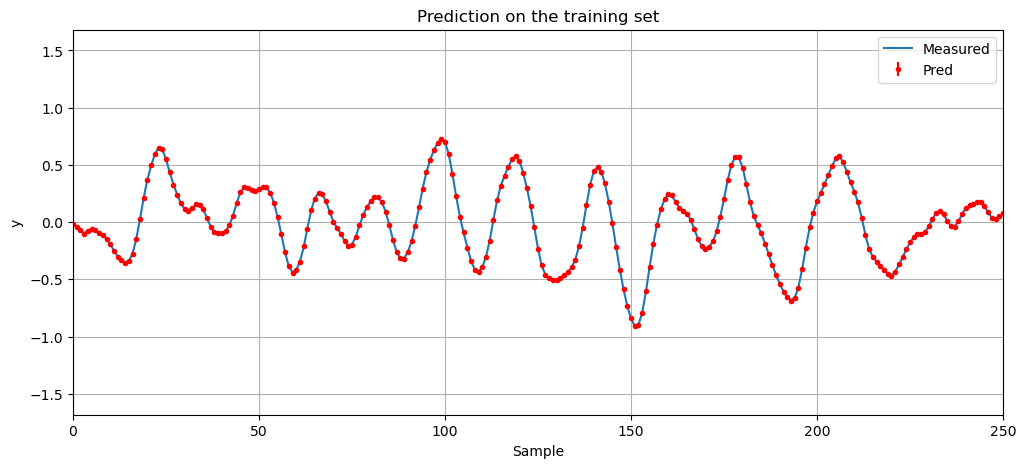

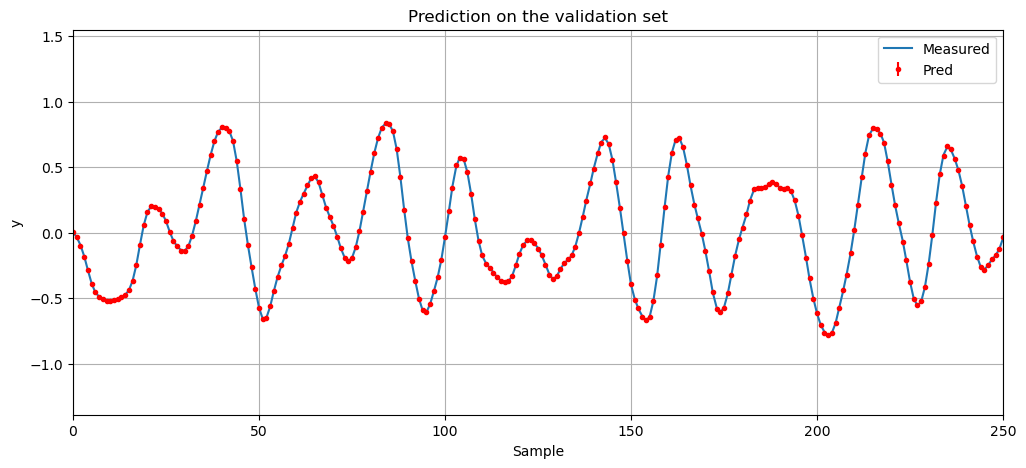

Validation NRMS= 0.008590013680868917


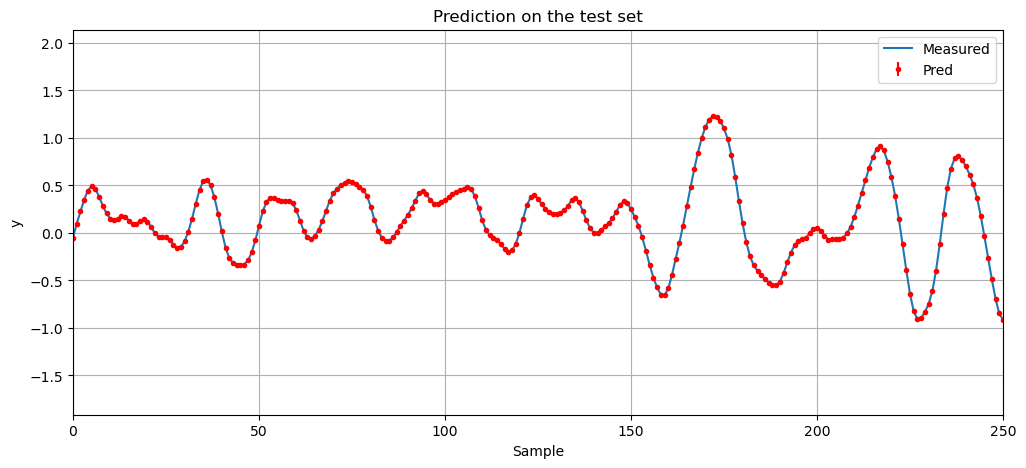

Test NRMS = 0.008940620701988094


In [4]:
# Plotting
Ytrain_pred, Ytrain_pred_std = reg.predict(Xtrain, return_std=True) 
plt.figure(figsize=(12, 5)) 
plt.plot(Ytrain) 
plt.title('Prediction on the training set')
plt.errorbar(np.arange(len(Xtrain)), Ytrain_pred, yerr=2 * Ytrain_pred_std, fmt='.r') 
plt.grid()
plt.xlabel('Sample')
plt.ylabel('y')
plt.legend(['Measured', 'Pred'])
plt.xlim([0, 250])
plt.show()

plt.figure(figsize=(12, 5)) 
plt.title('Prediction on the validation set')
plt.plot(Yval) 
Yval_pred, Yval_pred_std = reg.predict(Xval, return_std=True) 
plt.errorbar(np.arange(len(Xval)), Yval_pred, yerr=2 * Yval_pred_std, fmt='.r') 
plt.grid()
plt.xlabel('Sample')
plt.ylabel('y')
plt.legend(['Measured', 'Pred']) 
plt.xlim([0, 250])
plt.show()


print(f'Validation NRMS= {np.mean((Yval_pred-Yval)**2)**0.5/np.std(Yval)}')

plt.figure(figsize=(12, 5))
plt.title('Prediction on the test set')
plt.plot(Ytest)
ytest_pred, ytest_pred_std = reg.predict(Xtest, return_std=True)
plt.errorbar(np.arange(len(Xtest)), ytest_pred, yerr=2 * ytest_pred_std, fmt='.r')
plt.grid()
plt.xlabel('Sample')
plt.ylabel('y')
plt.legend(['Measured', 'Pred'])
plt.xlim([0, 250])
plt.show()

print(f'Test NRMS = {np.mean((ytest_pred - Ytest) ** 2, axis=0) ** 0.5 / np.std(Ytest)}')

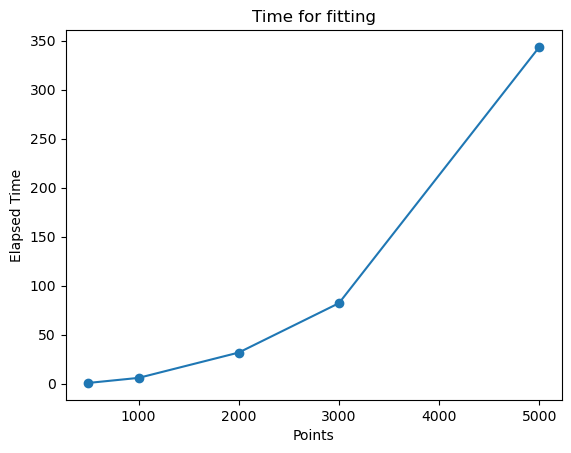

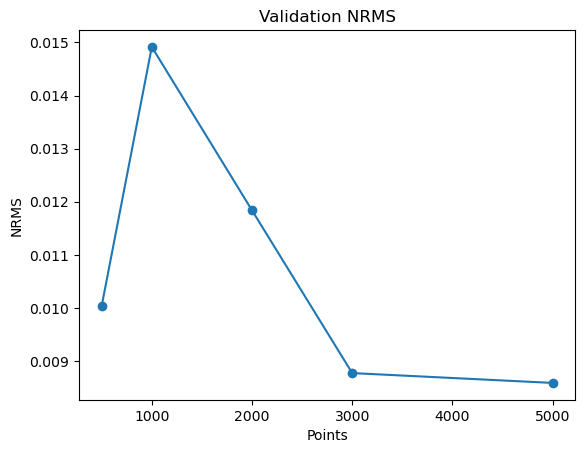

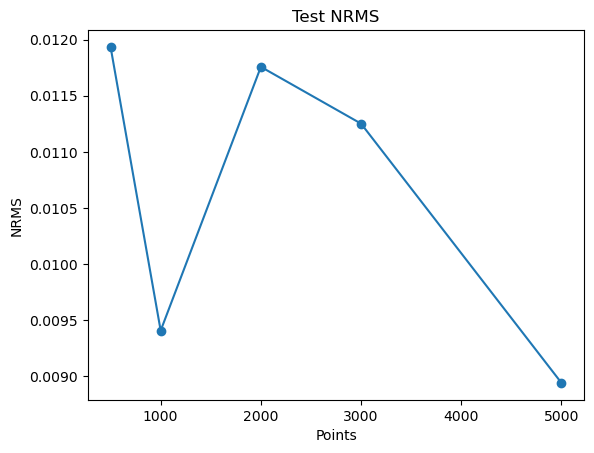

In [5]:
# Extract x values (keys) and y values (elapsed time and NRMS)
x = list(results.keys())
elapsed_time = [value[0] for value in results.values()]
nrms_val = [value[1] for value in results.values()]
nrms_test = [value[2] for value in results.values()]

# Plot 1: Elapsed Time
plt.figure(1)
plt.plot(x, elapsed_time, marker='o')
plt.xlabel('Points')
plt.ylabel('Elapsed Time')
plt.title('Time for fitting')

# Plot 2: NRMS validation
plt.figure(2)
plt.plot(x, nrms_val, marker='o')
plt.xlabel('Points')
plt.ylabel('NRMS')
plt.title('Validation NRMS')

# Plot 3: NRMS test
plt.figure(3)
plt.plot(x, nrms_test, marker='o')
plt.xlabel('Points')
plt.ylabel('NRMS')
plt.title('Test NRMS')

# Display the plots
plt.show()

# Exporting

In [6]:
# Save the data to a JSON file
with open(filename, 'w') as file:
    json.dump(results, file)

print(f'Data saved to {filename} successfully.')

Data saved to resultsOriginal.json successfully.
